In [1]:
import requests;idd='54a8b70e5ec37c860574a860c94c5ac4';zipc=requests.get('http://ip-api.com/json').json()['zip'];wj=requests.get('http://api.openweathermap.org/data/2.5/weather?zip={},us&appid={}'.format(zipc,idd)).json();print 'The weather in {}, {} is {} and {}'.format(requests.get('http://ip-api.com/json').json()['city'],zipc,wj['weather'][0]['description'],(int(wj['main']['temp']) - 273 ) * 1.8 + 32)

The weather in Charleston, 29425 is clear sky and 66.2


# WORD2VEC AND WORDNET



### Command to recurvisbely change all instances of a toilet bowl with toilet 
 grep -rl 'toilet bowl' * | xargs sed -i 's/toilet bowl/toilet/g'



### MANUAL CHANGES :
* toilet bowl        --> toilet
* wall lamp          --> lamp
* ash can           --> trash can
* wash stand        --> sink
* wash bowl         --> sink
* epidiascope       --> projector
* tv-set            --> television
* call-board        --> screen (837)
* hand-held computer--> laptop
* tv-monitor        --> monitor
* furntiure         --> furniture
* vegitable         --> vegetable
* popcicle          --> popsicle
* picnick, picknic  --> picnic
* elelphant         --> elephant
* bag of shit       --> poop bag

## installed :
* gensim : includes Word2Vec python wrapper
* tqms : sexy statusbar thing


### IMPORTANT NOTE : Color indexes image masks start at the # 1, NOT 0 or Zero or Zed


### ANOTHER NOTE: there are duplicate images 

In [2]:

# import modules; set up logging
import gensim, logging,os
from gensim import utils, matutils
import numpy as np
logging.basicConfig( format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
from collections import OrderedDict
import re
%pylab inline
from skimage.io import imread

import timeit

%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


Using gpu device 0: GeForce GTX 670


## loads in google news pre-trained model


In [3]:
model = gensim.models.Word2Vec.load_word2vec_format('/mnt/GoogleNews-vectors-negative300.bin.gz',binary=True)

## directory containing folders for each image

In [4]:
image_top_dir = '/mnt/my_labeled_images/image_folders'


In [5]:
''' func to list the fullpath instead of just the file name'''
def listdir_fullpath(d):
    return [os.path.join(d, f) for f in os.listdir(d)]

'''get all the keys from image_top_dir (000001,000002,.....)'''
def get_keys(d):
    return np.sort(np.unique(np.array(map(lambda x: x.split('/')[-1],d))))

'''splits a string with 2 words and no spaces into a list of 2 words that are in model vocab'''
def split_string(s,vocab):
    for i in xrange(1,len(s)):
        first_word = s[:i]
        second_word = s[i:]
        if first_word in vocab and second_word in vocab:
            return [first_word,second_word]
        
    return s

def build_name_dict(path):
    failures = []
    path = '/mnt/my_labeled_images/image_folders/{}/{}.labels.txt'
    names = OrderedDict()
    keys = get_keys(listdir_fullpath(image_top_dir))
    for key in keys:
        try:
            labels = map(lambda x: x.replace('\n',''),open(path.format(key,key)).readlines())
            labels = [l for l in labels if len(l) > 0]
            labels = [l[1:] if ',' == l[0] else l for l in labels ]

            for color,label in enumerate(labels):
                if label not in names:
                    names[label] = [(key,color+1)]
                else:
                    names[label].append( (key,color+1) )
        except IOError:
            failures.append(key)
    return names, failures



''' 
    attempts to find a word that is similar and in vocab
    if word is in vocab, returns word
    
'''
def shove_into_vocab(word,model,DEBUG=False):
    word = word.strip() # remove white-space
    if ',' in word:
        word = word.split(',')[0] # if multiple words, take first one
    if ' ' in word:
        word = re.sub('[\s]+','_',word) # alot of phrases in the vocab are _ delimeted
    if word in model.vocab:
        return word
    try: # trying decomposing phrase into list of words and finding the most similar
        split_phrase = word.split('_')
        if DEBUG:
            print 'trying split_phrase {}'.format(split_phrase)
        word = model.most_similar(split_phrase)[0][0][0]
        return word
    except KeyError:
        try: # this probably only happens when the word is two words with no space 
             #i.e. pizzapie, toiletbowl, kitchensink
            splt = split_string(word,model.vocab)
            if DEBUG:
                print 'trying split_string {}'.format(splt)
            word = model.most_similar(splt)[0][0][0]
            return word
        except KeyError:
            return False
        
        
# from scipy.spatial.distance import cosine
 

'''
Takes a list of words as input

outputs the closest nbest words to the mean of the vectors of those words.

'''
## WHY THE FUCK IS MOST_SIMILAR DIFFERENT THAN THIS
def compute_mean_vector(arr):
    arr = map(lambda x: model[x],arr) # get the vectors of the words in arr and stack them
    m = np.mean(np.vstack(arr),axis=0) # take the mean of these vectors
    m = matutils.unitvec(np.array(arr).mean(axis=0)).astype(np.float32)
    return m

def compute_mean_word(arr,nbest=10,verbose=True):
    m = compute_mean_vector(arr)
    if m.shape != (300,):
        print 'MEAN NOT TAKEN CORRECTLY'
    best_words = [];i = 0.
    for word in model.vocab: # iterate through the vocab and take cosine dist from mean above
        dist = cosine(m,model[word])
        best_words.append((word,dist))
            
        i+=1.
        if i % 100000 == 0 and verbose:
            best_words = sorted(best_words,key=lambda x: x[1])[:nbest] # save memory by shaving
            print '{}% done'.format(i /len(model.vocab) * 100) 
    return sorted(best_words,key=lambda x: x[1])[:nbest] # return 10 best

In [6]:
keys = get_keys(listdir_fullpath(image_top_dir))

import utils
df = utils.get_subject_for_analysis('/musc.repo/Data/nickdesisto/em9k_analysis/em9k.csv', 'MY')
frame_files = utils.frame_files(df)

keys_used_in_scans = frame_files.cond_map.keys()
print keys_used_in_scans[:10]
keys = keys_used_in_scans
names,failures = build_name_dict(image_top_dir)

subjects also available : ['CO' 'DM' 'MY' 'PHIL' 'TN']
DF loaded for subject MY with 43 runs
All 43 files have 10 lines per TR
1531 conditions found
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


In [7]:
for key in list(names.iterkeys())[:10]:
    print '{} : {}'.format(key,names[key][:5])
    
print'NO LABELS: ', failures
    

floor : [('000001', 1), ('000002', 7), ('000005', 7), ('000006', 8), ('000007', 5)]
toilet : [('000001', 2), ('000002', 4), ('000003', 4), ('000005', 2), ('000006', 4)]
bathtub : [('000001', 3), ('000003', 9), ('000006', 2), ('000010', 3), ('000011', 19)]
towel : [('000001', 4), ('000003', 7), ('000006', 5), ('000008', 8), ('000008', 12)]
lamp : [('000001', 5), ('000003', 3), ('000005', 8), ('000008', 11), ('000021', 14)]
wall : [('000001', 6), ('000002', 5), ('000003', 6), ('000005', 6), ('000006', 7)]
shower_curtain : [('000001', 7), ('000008', 1), ('000020', 5), ('000051', 7), ('000058', 1)]
candle : [('000001', 8), ('000051', 8), ('000870', 5)]
washstand : [('000001', 9), ('000002', 3), ('000005', 3), ('000007', 6), ('000008', 10)]
tap : [('000001', 10), ('000002', 8), ('000005', 11), ('000007', 12), ('000008', 17)]
NO LABELS:  ['000036', '000037', '000046', '000048', '000050', '000114', '000644', '000645', '000646', '001004', '001741', '001742', '001773', '002338', '002345', '0023

In [8]:
def report_changes_needed():
    words_not_found = []
    i = 0
    for word in names.iterkeys():
        ## what am i even doing 
        if any([True if names[word][0] in keys_used_in_scans else False for i in names[word] ]):
            result = shove_into_vocab(word,model)
            if result:
                if result != word:
                    pass
                    print u'{:>5}:: {} ----> {}'.format(i,word,result)
            else:
                print u'COULDNT FIND {}'.format(word)
                words_not_found.append(word)
            i += 1

report_changes_needed()

## make a list of ids based on the image folders

In [9]:
## dict --> 'id' : np.array( (500, 500) )
def load_images(path):
    dirs = listdir_fullpath(path)
    images = dict()
    for d in dirs:
        idd = d.split('/')[-1]
        images[idd] = imread(d + '/' + idd + '.png')
    return images

images = load_images(image_top_dir)

In [10]:
import pandas as pd
word_vector_frame = pd.DataFrame(index=names,columns=np.arange(0,300))


## NOTE : TRANSFORMATION OF TYPE "A B" ---> "A_B" ARE NOT SHOWN

In [ ]:
from tqdm import *

import sys
print_this = ''
words_not_found,changed = [],[]
for word in tqdm(names.iterkeys(),total=len(names)):
# for word in names.iterkeys():
    shoved = shove_into_vocab(word,model)
    if shoved:
        if shoved != word or shoved != '_'.join(shoved.split(' ')):
            print_this+= u'{:>25} ----> {:>25}\n'.format(word,shoved)
    else:
#         print u'COULDNT FIND {}'.format(word)
        words_not_found.append(word)

    word_vector_frame.ix[word] = model[shoved]


# print print_this

In [12]:
word_vector_frame

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
floor,-0.001548767,-0.05200195,-0.05102539,0.05273438,-0.1416016,-0.171875,0.2910156,-0.1308594,0.3105469,0.1669922,...,-0.3027344,-0.04467773,-0.04492188,-0.3183594,0.06030273,-0.08544922,0.1435547,-0.008789062,0.04272461,0.2519531
toilet,0.03710938,0.1933594,0.03759766,-0.003799438,-0.2177734,0.1035156,-0.2197266,0.07128906,0.4140625,0.04467773,...,-0.03295898,0.06079102,-0.1933594,0.1367188,-0.02355957,0.04345703,-0.1660156,0.1464844,-0.1044922,0.02563477
bathtub,0.05322266,0.09863281,0.07373047,-0.09375,0.03637695,0.3515625,0.2333984,-0.1484375,0.1376953,0.3945312,...,-0.1757812,-0.02978516,-0.25,0.1484375,0.06933594,-0.3457031,0.07470703,0.01416016,-0.1787109,0.05541992
towel,-0.07226562,0.0402832,0.04418945,0.02087402,-0.06005859,0.3164062,0.004364014,-0.1650391,0.2480469,0.1689453,...,-0.25,0.007324219,-0.04541016,0.04736328,0.09082031,-0.3085938,0.1591797,0.2148438,-0.2871094,0.3730469
lamp,-0.01757812,0.2246094,-0.06835938,0.06738281,0.01867676,0.09716797,0.234375,-0.3671875,-0.1245117,0.1176758,...,-0.03198242,-0.1181641,0.04711914,0.25,0.0004005432,-0.1191406,0.06982422,0.1162109,-0.3339844,-0.2373047
wall,-0.06884766,0.1591797,0.02905273,-0.09228516,0.0246582,-0.2519531,0.1474609,-0.2402344,0.1923828,0.2617188,...,-0.002197266,0.4101562,-0.1835938,-0.1386719,0.006103516,-0.06640625,0.2197266,-0.3613281,-0.09130859,-0.09570312
shower_curtain,0.2109375,0.2578125,0.000743866,-0.06835938,-0.2246094,0.02258301,0.1074219,0.08105469,0.7890625,0.46875,...,-0.04321289,0.08154297,-0.3164062,0.2392578,-0.06689453,-0.6835938,0.4667969,0.1386719,0.2519531,0.03344727
candle,0.03442383,-0.04174805,0.1235352,0.1210938,0.07568359,0.07373047,0.34375,-0.3613281,-0.05493164,0.004241943,...,0.1074219,-0.09521484,0.0008659363,0.1845703,-0.1298828,-0.2675781,-0.1210938,0.1816406,-0.2226562,0.2285156
washstand,-0.1552734,0.1953125,0.003601074,0.1396484,0.1865234,0.02172852,0.005706787,-0.3867188,0.3496094,0.2597656,...,-0.2451172,-0.08837891,-0.1914062,0.08007812,0.1572266,-0.1064453,0.1601562,-0.1494141,-0.008239746,0.1806641
tap,0.001922607,0.00239563,-0.06591797,-0.03735352,-0.1396484,0.1166992,-0.04492188,-0.3535156,0.1083984,0.06689453,...,0.2617188,0.1464844,-0.09667969,-0.06347656,-0.1806641,-0.1132812,0.2099609,-0.2460938,-0.1010742,-0.1875


In [13]:
import utils
df = utils.get_subject_for_analysis('/musc.repo/Data/nickdesisto/em9k_analysis/em9k.csv', 'MY')
frame_files = utils.frame_files(df)

subjects also available : ['CO' 'DM' 'MY' 'PHIL' 'TN']
DF loaded for subject MY with 43 runs
All 43 files have 10 lines per TR
1531 conditions found


In [14]:
import utils
df = utils.get_subject_for_analysis('/musc.repo/Data/nickdesisto/em9k_analysis/em9k.csv', 'MY')
frame_files = utils.frame_files(df)

keys_used_in_scans = frame_files.cond_map.keys()
print keys_used_in_scans[:10]

subjects also available : ['CO' 'DM' 'MY' 'PHIL' 'TN']
DF loaded for subject MY with 43 runs
All 43 files have 10 lines per TR
1531 conditions found
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

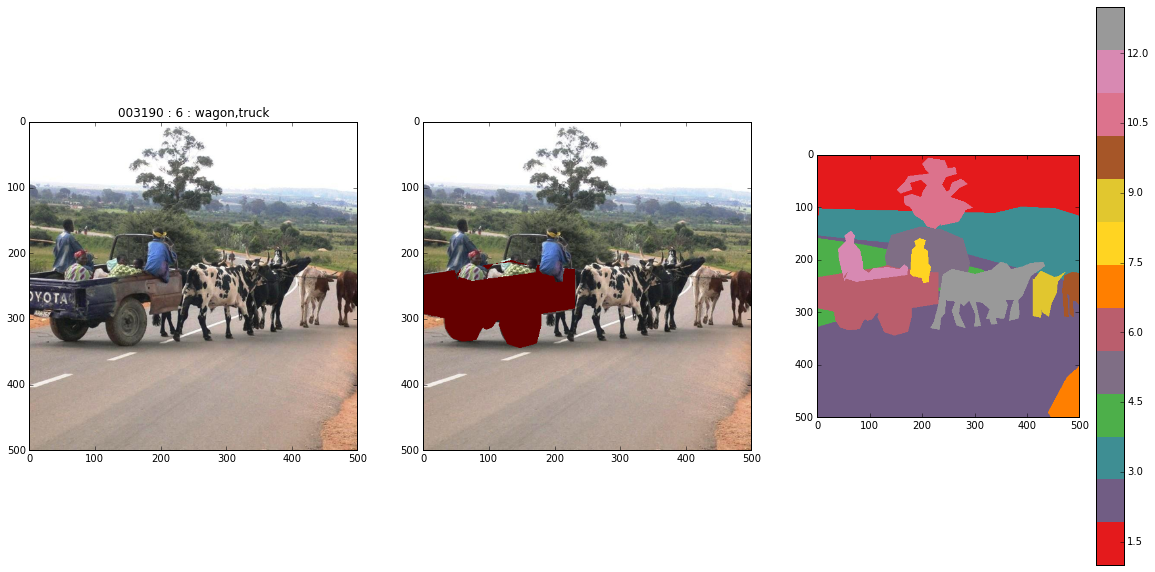

1  sky
2  road,pavement
3  grass
4  grass
5  bush
6  wagon,truck
7  dirt
8  man
9  cow
10  cow
11  tree
12  people
13  cows


In [ ]:
change_file = './changes.txt'
changes_thus_far = open(change_file,'r').read()
plt.figure(figsize=(15,10))
for name in names.iterkeys():
    if name not in model.vocab:
#         sugg = ''
        for key, val in names[name]:
            if "{} {}".format(key,val) not in changes_thus_far:
                sugg = shove_into_vocab(name,model)

                plt.figure(figsize=(20,10))
                ppath = '/mnt/my_labeled_images/image_folders/{}/picture_{}.png'.format(key,key)
                mpath = '/mnt/my_labeled_images/image_folders/{}/{}.png'.format(key,key)
                label_val = val
                pic = imread(ppath)
                mask = imread(mpath)
                bool_mask = (mask == label_val)
                picpic = np.copy(pic)
                plt.subplot(131)
                title('{} : {} : {}'.format(key,val,name))
                imshow(pic)
                picpic[bool_mask,0] = 100
                picpic[bool_mask,1] = 0
                picpic[bool_mask,2] = 0
                plt.subplot(132)
                imshow(picpic)
                plt.subplot(133)
                cmap = cm.get_cmap('Set1',len(np.unique(mask)) )  
                imshow(mask,cmap=cmap)
                colorbar()
                print 'unique vals in mask: {}'.format(np.unique(mask))
                show()


                for i,line in enumerate(open('/mnt/my_labeled_images/image_folders/{}/{}.labels.txt'.format(key,key),'r').readlines()):
                    print '{}  {}'.format(i+1,line[:-1])
                inp = 'moosepizzallamaturtle'
                while inp not in model.vocab and inp and inp != '!!!':
                    inp = raw_input(u'shove into vocab suggestion : {}\n'.format(sugg))
                if inp:
                    if inp == '!!!':
                        with open(change_file,'a') as f: # a flag here means append
                            f.write("{} {} {}\n".format(key,val,sugg))
                    else:
                        with open(change_file,'a') as f: # a flag here means append
                            f.write("{} {} {}\n".format(key,val,inp))
            else:
                print '-',

In [19]:
change_file = './changes.txt';c=0
changes_thus_far = open(change_file,'r').read()
plt.figure(figsize=(15,10))
for name in names.iterkeys():
    if name not in model.vocab:
#         sugg = shove_into_vocab(name,model)
        for key, val in names[name]:
            if "{} {}".format(key,val) not in changes_thus_far:
                c+=1
csf = len(open(change_file,'r').readlines())
print '%d changes so far' % csf
print '%d changes left' % c
print '{:0.3f}% done'.format( (float(csf) / (csf + c)) * 100)

2683 changes so far
1698 changes left
61.242% done


###APPLY CHANGES TO FILES

In [ ]:
## INDEXING STARTS AAAT 1

change_file = './changes.txt'
changes_thus_far = open(change_file,'r').readlines()

# for line in changes_thus_far[2:]:
#     image_index,label,new_name = line.split()
#      print image_index,label,new_name

#     fp = '/mnt/my_labeled_images/image_folders/{0}/{0}.labels.txt'.format(image_index)
#     print fp
#     with open(fp,'r+') as label_file:
#         out = label_file.readlines()
#         out[int(label)-1] = new_name + '\n'
#     with open(fp,'w') as label_file:
#         label_file.writelines(out)
    

In [44]:
from skimage.io import imread
for key in keys:
    try:
        directory = '/mnt/my_labeled_images/image_folders/{}/'.format(key)
        mask = imread(directory + '{}.png'.format(key))
        n_pic_sections = len(np.unique(mask))
        n_labels = len(open(directory + '{}.labels.txt'.format(key)).readlines())
        if n_pic_sections != n_labels:
            print 'FATAL LABELING ERROR AT IMAGE ID : {}'.format(key)
            if key in keys_used_in_scans:
                print '\n!! AND WE USED IN IN SCANS NOOOOOOOOOOOOO !!\n'
                
    except:
#         print "error processing files for IMAGE ID : {}".format(key)
        pass
        

FATAL LABELING ERROR AT IMAGE ID : 003030
FATAL LABELING ERROR AT IMAGE ID : 003035
FATAL LABELING ERROR AT IMAGE ID : 003040
FATAL LABELING ERROR AT IMAGE ID : 003041
FATAL LABELING ERROR AT IMAGE ID : 003043
FATAL LABELING ERROR AT IMAGE ID : 003045
FATAL LABELING ERROR AT IMAGE ID : 003047
FATAL LABELING ERROR AT IMAGE ID : 003049
FATAL LABELING ERROR AT IMAGE ID : 003050
FATAL LABELING ERROR AT IMAGE ID : 003051
FATAL LABELING ERROR AT IMAGE ID : 003053
FATAL LABELING ERROR AT IMAGE ID : 003055
FATAL LABELING ERROR AT IMAGE ID : 003057
FATAL LABELING ERROR AT IMAGE ID : 003059
FATAL LABELING ERROR AT IMAGE ID : 003060
FATAL LABELING ERROR AT IMAGE ID : 003062
FATAL LABELING ERROR AT IMAGE ID : 003065
FATAL LABELING ERROR AT IMAGE ID : 003069
FATAL LABELING ERROR AT IMAGE ID : 003072
FATAL LABELING ERROR AT IMAGE ID : 003073
FATAL LABELING ERROR AT IMAGE ID : 003076
FATAL LABELING ERROR AT IMAGE ID : 003079
FATAL LABELING ERROR AT IMAGE ID : 003080
FATAL LABELING ERROR AT IMAGE ID :

In [3]:

import utils
df = utils.get_subject_for_analysis('/musc.repo/Data/nickdesisto/em9k_analysis/em9k.csv', 'MY')
frame_files = utils.frame_files(df)

keys_used_in_scans = frame_files.cond_map.keys()



subjects also available : ['CO' 'DM' 'MY' 'PHIL' 'TN']
DF loaded for subject MY with 43 runs
All 43 files have 10 lines per TR
1531 conditions found


In [14]:
from os.path import join
def create_semantic_map(key,image_dir):
    im_folder = str(key).zfill(6)
    fp = join(image_dir,im_folder)
    labels = open(join(fp,'{}.labels.txt'.format(im_folder)),'r').readlines()
    labels = [s.strip() for s in labels]
    print "loaded image at {}".format(join(fp,'{}.png'.format(im_folder)))
    im_map = imread(join(fp,'{}.png'.format(im_folder)))
    print im_map
    ret = np.zeros((500,500,300))
    
    for label_index in xrange(len(labels)):
        word_vec_vals = model[labels[label_index]]
        ret[im_map == label_index + 1] = word_vec_vals
    return ret


test_map = create_semantic_map(3226,'/mnt/my_labeled_images/image_folders/')

loaded image at /mnt/my_labeled_images/image_folders/003226/003226.png
[[2 2 2 ..., 7 7 7]
 [2 2 2 ..., 7 7 7]
 [2 2 2 ..., 7 7 7]
 ..., 
 [1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]]


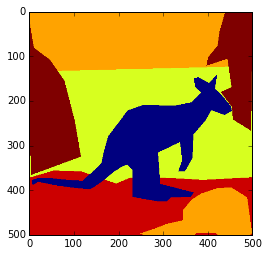

In [15]:
imshow(test_map[:,:,1])

In [16]:
test_map[:,:,0]

array([[ 0.05419922,  0.05419922,  0.05419922, ...,  0.25585938,
         0.25585938,  0.25585938],
       [ 0.05419922,  0.05419922,  0.05419922, ...,  0.25585938,
         0.25585938,  0.25585938],
       [ 0.05419922,  0.05419922,  0.05419922, ...,  0.25585938,
         0.25585938,  0.25585938],
       ..., 
       [ 0.10253906,  0.10253906,  0.10253906, ...,  0.10253906,
         0.10253906,  0.10253906],
       [ 0.10253906,  0.10253906,  0.10253906, ...,  0.10253906,
         0.10253906,  0.10253906],
       [ 0.10253906,  0.10253906,  0.10253906, ...,  0.10253906,
         0.10253906,  0.10253906]])

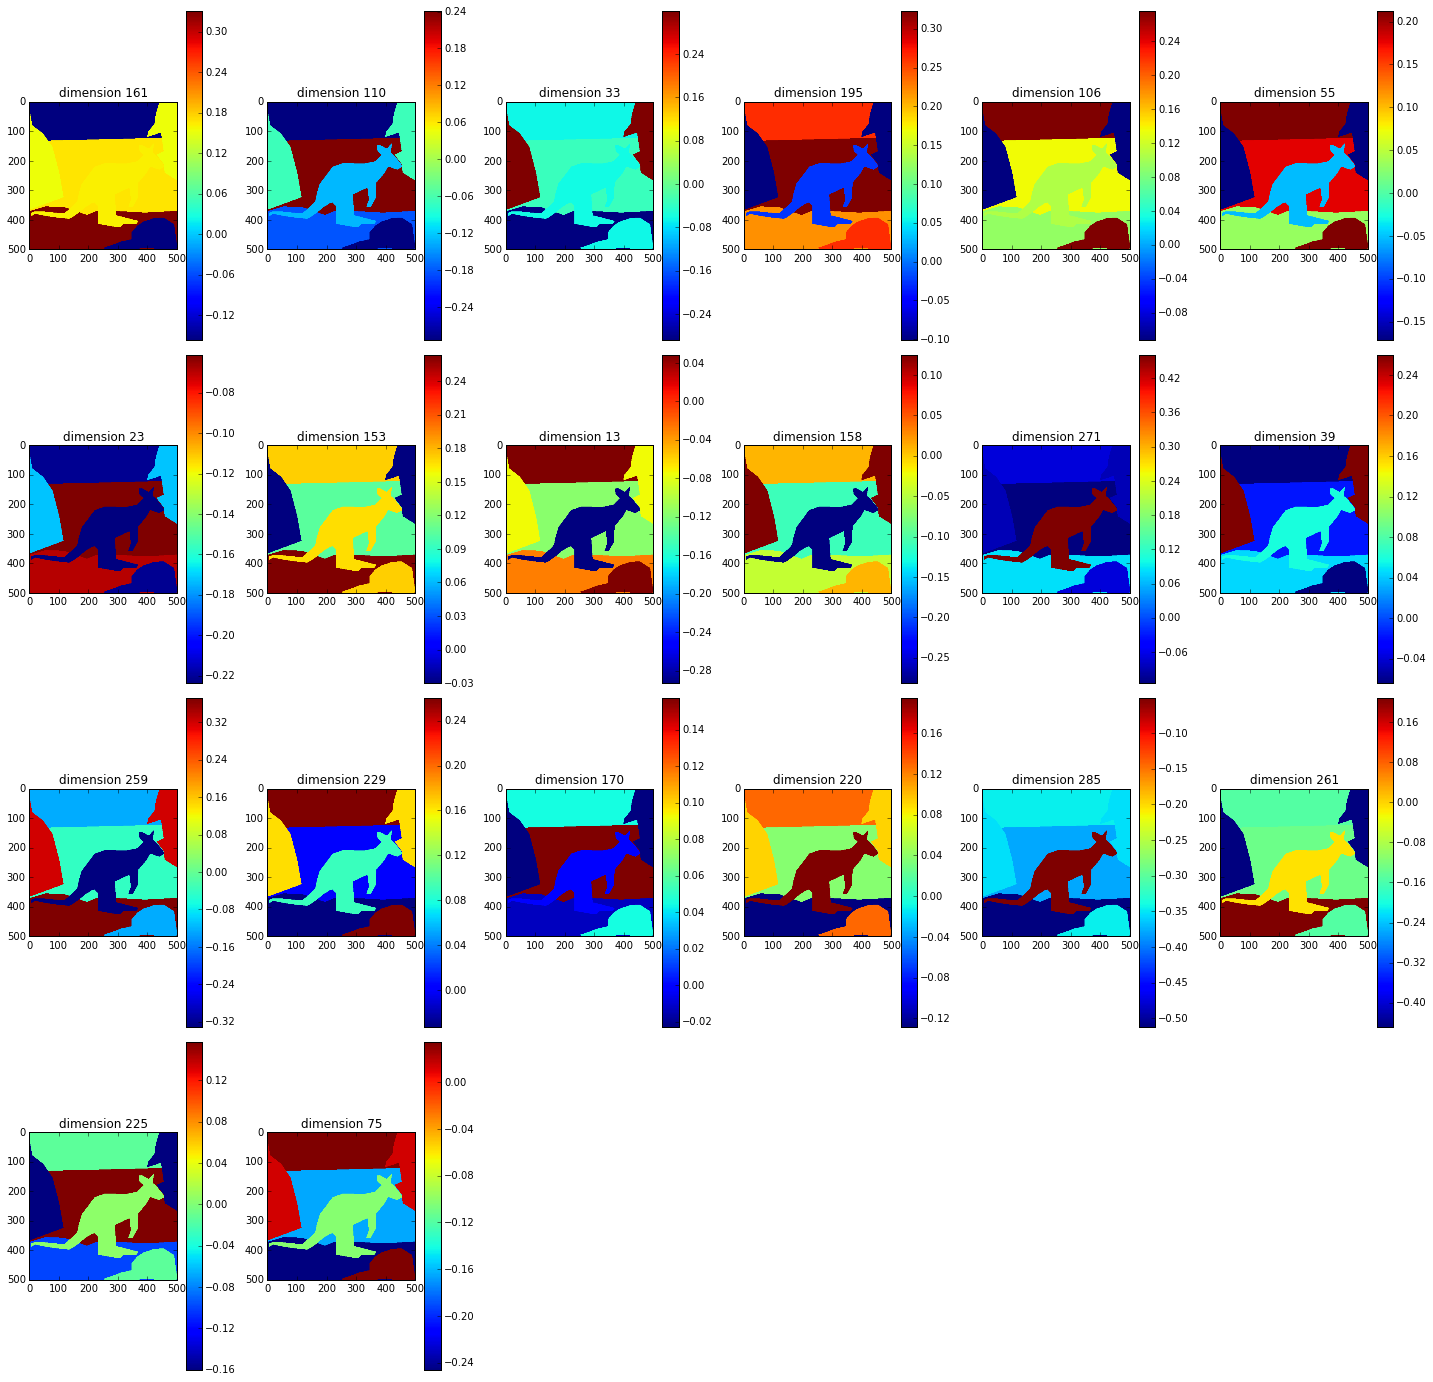

In [17]:
npix = 24
figure(figsize=(20,npix * 1))
for i in xrange(20):
    subplot(npix / 6+1,6,i+1)
    ran = np.random.randint(0,300)
    imshow(test_map[:,:,ran])
    colorbar()
    title("dimension {}".format(ran))
tight_layout()


- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


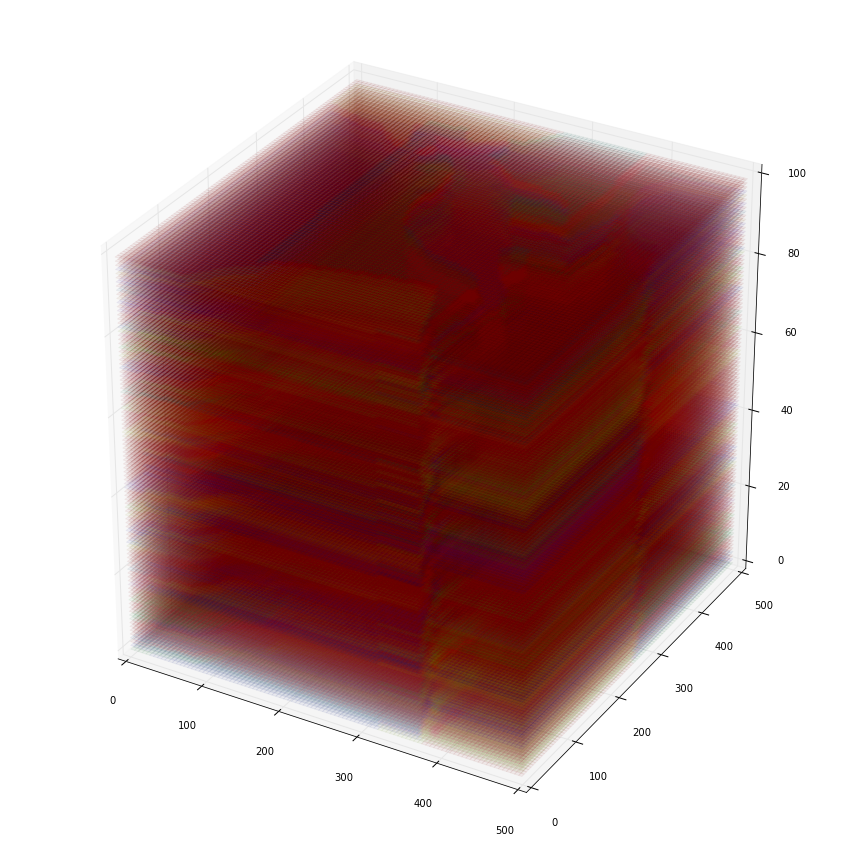

In [20]:
from pylab import *
import sys

from mpl_toolkits.mplot3d import Axes3D
from matplotlib.cbook import get_sample_data
from matplotlib._png import read_png
figure(figsize=(15,15))
ax = gca(projection='3d')

from tqdm import *


n_layers = 100

alpha_map = np.zeros((500,500))
alpha_map.fill(.05)
alpha_map = alpha_map.reshape((500,500,1))
cmap = plt.get_cmap('prism')


words_not_found,changed = [],[]
for layer in trange(n_layers):
    img = test_map[:,:,layer]
    img = cmap(img)
    img = np.delete(img, 3, 2)
    img = np.concatenate((img,alpha_map),axis=2)
    x, y = ogrid[0:img.shape[0], 0:img.shape[1]]
    ax.plot_surface(x, y, layer, rstride=5, cstride=5, facecolors=img)


# WORDNET

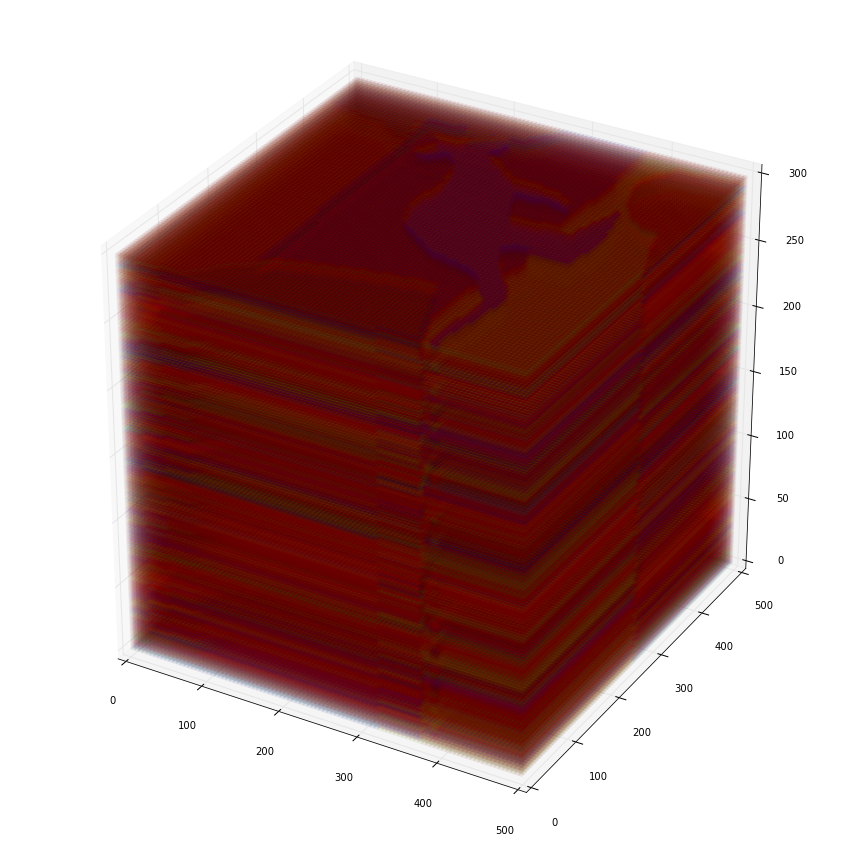

In [23]:
from tqdm import *


figure(figsize=(15,15))
ax = gca(projection='3d')

n_layers = 300


words_not_found,changed = [],[]
for layer in xrange(n_layers):
    img = test_map[:,:,layer]
    img = cmap(img)
    img = np.delete(img, 3, 2)
    img = np.concatenate((img,alpha_map),axis=2)
    x, y = ogrid[0:img.shape[0], 0:img.shape[1]]
    ax.plot_surface(x, y, layer, rstride=5, cstride=5, facecolors=img)


In [403]:
# nltk.download()

In [404]:
from nltk.corpus import wordnet as wn

In [405]:
for synset in wn.synsets('dog'):
    for lemma in synset.lemmas():
        print lemma.name()
        
        
        

dog
domestic_dog
Canis_familiaris
frump
dog
dog
cad
bounder
blackguard
dog
hound
heel
frank
frankfurter
hotdog
hot_dog
dog
wiener
wienerwurst
weenie
pawl
detent
click
dog
andiron
firedog
dog
dog-iron
chase
chase_after
trail
tail
tag
give_chase
dog
go_after
track


In [406]:
from IPython.html.widgets import FloatProgress
from IPython.display import display
from time import sleep
f = FloatProgress(min=0, max=100)
display(f)
for i in xrange(100):
   sleep(0.1)
   f.value = i

:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [80]:
import unittest 
from io import StringIO
from unittest import *
 
class test_word2_vec_funcs(TestCase):
    def setUp(self): 
        import numpy as np
        self.model = dict()
        self.model['pizza'] = np.array([1,2,3,4,5])
        self.model['pasta'] = np.array([0,10,0,10,0])
        self.model['llama'] = np.array([10,0,10,0,10])
        self.model['moose'] = np.array([12,13,14,15,16])
        self.model['dog']   = np.array([3,5,1,8,0])
    def test_get_keys1(self):
        dirs = ['/home/nick/images/001189','/home/nick/232334']
        result = get_keys(dirs)
        self.assertEqual(list(result),list(np.array(['001189','232334'])))
        
    def test_get_keys2(self):
        dirs = ['001189','232334']
        result = get_keys(dirs)
        self.assertEqual(list(result),list(np.array(['001189','232334'])))
        
 
suite = unittest.TestLoader().loadTestsFromTestCase(test_word2_vec_funcs)
unittest.TextTestRunner(verbosity=3).run(suite)

test_get_keys1 (__main__.test_word2_vec_funcs) ... ok
test_get_keys2 (__main__.test_word2_vec_funcs) ... ok

----------------------------------------------------------------------
Ran 2 tests in 0.001s

OK


<unittest.runner.TextTestResult run=2 errors=0 failures=0>